<a href="https://colab.research.google.com/github/NoraNekoIT/Identifikasi-burung-dengan-gambar/blob/main/ProjectAkhirAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pengidentifikasi spesies burung dengan menggunakan gambar

> Antonius Bun Wijaya | 19340013 

> Artificial Intellegence | Project Akhir Pemula✌

> **Progress** ✅

### Deep Learning

## Birds Custom CNN

In [29]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import itertools


In [6]:
#masukkan kaggle api anda
! chmod 600 /content/kaggle.json

In [7]:
#masukkan link dataset kaggle
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d kedarsai/bird-species-classification-220-categories


100% 1.05G/1.06G [00:09<00:00, 147MB/s]
100% 1.06G/1.06G [00:09<00:00, 121MB/s]


In [8]:
#extract datanya 
import zipfile

zip_file = zipfile.ZipFile('/content/bird-species-classification-220-categories.zip',
                           'r')
zip_file.extractall('/tmp/')

In [9]:
# declare untuk semua image akan diconvert ukurannya
ROWS = 256 
COLS = 256
CHANNELS = 3

In [10]:
train_image_generator = ImageDataGenerator(horizontal_flip=True,
                                           rescale=1./255, 
                                           rotation_range=45)
test_image_generator = ImageDataGenerator(horizontal_flip=False, 
                                          rescale=1./255, 
                                          rotation_range=0)

train_generator = train_image_generator.flow_from_directory('/tmp/Train', 
                                                            target_size=(ROWS,COLS) ,
                                                            batch_size=32,
                                                            class_mode='categorical')
test_generator = test_image_generator.flow_from_directory('/tmp/Test', 
                                                          target_size=(ROWS,COLS) , 
                                                          batch_size =32,
                                                          class_mode='categorical')

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [11]:
train_generator.reset()
test_generator.reset()

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(ROWS, COLS, CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(200))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adamax',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 252, 252, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [12]:

tensorboard = TensorBoard(log_dir='./logs/custom')

model.fit(train_generator, 
          steps_per_epoch=512,
          epochs=10, 
          callbacks=[tensorboard], 
          verbose=2)


Epoch 1/10
512/512 - 220s - loss: 5.2983 - accuracy: 0.0042 - 220s/epoch - 429ms/step


In [13]:
print(model.evaluate(test_generator, steps=1000))

1000/1000 [==============================] - 15s 15ms/step - loss: 5.2657 - accuracy: 0.0147
[5.26565408706665, 0.014743049629032612]


## Birds Inception Train

In [14]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import itertools

In [15]:
# membuat base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# menambahkan global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# menambahkan fully-connected layer
x = Dense(1024, activation='relu')(x)
out_layer = Dense(200, activation='softmax')(x)

#  model akan kita train
model = Model(inputs=base_model.input, outputs=out_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [16]:
# pertama: train hanya top layers (yang diinisiasi secara acak)
# freeze semua convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_4 (Conv2D)              (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d_4[0][0]']               
 alization)                     32)                                                           

In [17]:
tensorboard = TensorBoard(log_dir='./logs')

model.fit(train_generator, steps_per_epoch=32, epochs=100, 
          callbacks=[tensorboard], verbose=2)

Epoch 1/100
32/32 - 27s - loss: 6.1364 - accuracy: 0.0400 - 27s/epoch - 858ms/step
Epoch 2/100
32/32 - 21s - loss: 4.5896 - accuracy: 0.0703 - 21s/epoch - 651ms/step
Epoch 3/100
32/32 - 21s - loss: 4.0207 - accuracy: 0.1270 - 21s/epoch - 652ms/step
Epoch 4/100
32/32 - 21s - loss: 3.6096 - accuracy: 0.1680 - 21s/epoch - 663ms/step
Epoch 5/100
32/32 - 21s - loss: 3.2134 - accuracy: 0.2432 - 21s/epoch - 645ms/step
Epoch 6/100
32/32 - 21s - loss: 3.1785 - accuracy: 0.2285 - 21s/epoch - 646ms/step
Epoch 7/100
32/32 - 21s - loss: 2.9367 - accuracy: 0.2539 - 21s/epoch - 648ms/step
Epoch 8/100
32/32 - 21s - loss: 2.7748 - accuracy: 0.2998 - 21s/epoch - 646ms/step
Epoch 9/100
32/32 - 20s - loss: 2.6721 - accuracy: 0.3086 - 20s/epoch - 640ms/step
Epoch 10/100
32/32 - 20s - loss: 2.6023 - accuracy: 0.3145 - 20s/epoch - 639ms/step
Epoch 11/100
32/32 - 21s - loss: 2.6301 - accuracy: 0.3027 - 21s/epoch - 644ms/step
Epoch 12/100
32/32 - 21s - loss: 2.4523 - accuracy: 0.3408 - 21s/epoch - 651ms/step
E

In [18]:
print(model.evaluate(test_generator, steps=5000))


5000/5000 [==============================] - 20s 4ms/step - loss: 1.8396 - accuracy: 0.5388
[1.8395737409591675, 0.5387531518936157]


In [20]:
# unfreeze semua layers untuk training
for layer in model.layers:
    layer.trainable = True

# kita perlu mengkompilasi ulang model agar modifikasi ini dapat diterapkan
# kita gunakan SGD dengan low learning rate
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, steps_per_epoch=32, epochs=100)

Epoch 1/100
32/32 [==============================] - 37s 888ms/step - loss: 1.8678 - accuracy: 0.5078
Epoch 2/100
32/32 [==============================] - 30s 912ms/step - loss: 1.6870 - accuracy: 0.5498
Epoch 3/100
32/32 [==============================] - 29s 896ms/step - loss: 1.5752 - accuracy: 0.5791
Epoch 4/100
32/32 [==============================] - 29s 882ms/step - loss: 1.6266 - accuracy: 0.5518
Epoch 5/100
32/32 [==============================] - 29s 892ms/step - loss: 1.4114 - accuracy: 0.6092
Epoch 6/100
32/32 [==============================] - 28s 871ms/step - loss: 1.4128 - accuracy: 0.6074
Epoch 7/100
32/32 [==============================] - 29s 885ms/step - loss: 1.3879 - accuracy: 0.6016
Epoch 8/100
32/32 [==============================] - 29s 890ms/step - loss: 1.2700 - accuracy: 0.6514
Epoch 9/100
32/32 [==============================] - 29s 879ms/step - loss: 1.1825 - accuracy: 0.6562
Epoch 10/100
32/32 [==============================] - 29s 877ms/step - loss: 1.259

In [22]:
test_generator.reset()
print(model.evaluate(test_generator, steps=5000))

5000/5000 [==============================] - 21s 3ms/step - loss: 1.0952 - accuracy: 0.6988
[1.0951708555221558, 0.6988205313682556]


In [23]:
model.save("birds-inceptionv3.model")

INFO:tensorflow:Assets written to: birds-inceptionv3.model/assets


## Birds Inception Predict

In [30]:
from keras.models import load_model
from keras.preprocessing import image
from os import listdir
from google.colab import files
import numpy as np
from matplotlib import pyplot as plt

In [25]:
ROWS = 256
COLS = 256

In [26]:
CLASS_NAMES = sorted(listdir('/tmp/Train'))

model = load_model('birds-inceptionv3.model')

In [54]:
def predict(fname):
    img = image.load_img(fname, target_size=(ROWS, COLS))
    #Menampilkan image
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    img_tensor = image.img_to_array(img) # (height, width, channels)
    # (1, height, width, channels), tambahkan dimensi untuk model menentukan expects 
    # (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor /= 255. # model expects nilai range [0, 1]
    prediction = model.predict(img_tensor)[0]
    best_score_index = np.argmax(prediction)
    bird = CLASS_NAMES[best_score_index] # mengambil nama class asli
    print("""Prediksi, hmph kupikir ini jenis %s 
          aku memperkirakan akurasinya sebesar(%.2f%%)""" 
          % (bird, 100*prediction[best_score_index]))

Prediksi, hmph kupikir ini jenis Pacific_Loon 
          aku memperkirakan akurasinya sebesar(30.31%)


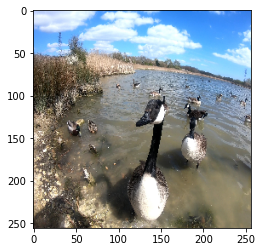

In [55]:
predict('/tmp/canada_goose_1.JPG')